## Vamos a comprobar si hay una relación entre la estación del año y la agresividad del tiburón, es decir si el ataque es mortal.

In [1]:
import re
import pandas as pd
import numpy as np
import src.utils as u

### Cargamos el dataset

In [2]:
shark_attack = pd.read_csv("./INPUT/GSAF5.csv", encoding = "ISO-8859-1")
pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 500)
shark_attack.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN


### Vamos a ver que tienen las dos últimas columnas:

In [3]:
print(print(shark_attack.shape))
nullvals = shark_attack[["Unnamed: 22", "Unnamed: 23"]].isnull().sum()[shark_attack.isnull().sum() > 0]
print(nullvals)

(5992, 24)
None
Unnamed: 22    5991
Unnamed: 23    5990
dtype: int64


In [4]:
print(shark_attack["Unnamed: 22"].value_counts())
print("________________________________________")
print(shark_attack["Unnamed: 23"].value_counts())

stopped here    1
Name: Unnamed: 22, dtype: int64
________________________________________
Teramo             1
change filename    1
Name: Unnamed: 23, dtype: int64


### No tienen nada interesante, podemos eliminarlas

In [5]:
sa = shark_attack[shark_attack.columns[:-2]]

### Renombramos Fatal(Y/N) a Fatal y comprobamos si las columnas que no tienen valor en Fatal no deben tenerlo

In [6]:
sa = sa.rename(columns={'Fatal (Y/N)':'Fatal'})
sa.columns

Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal', 'Time',
       'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order'],
      dtype='object')

In [7]:
sa_incorrect_fatal_values = sa[[ 'Injury', 'Fatal']] [u.is_not_this("N", "Y", lst = sa['Fatal'])]
print(len(sa_incorrect_fatal_values))
sa_incorrect_fatal_values.head()

125


,Injury,Fatal
54,"No injury, but sharks repeatedly hit their fin...",NaN
401,No details,UNKNOWN
1047,NaN,UNKNOWN
1142,NaN,UNKNOWN
1844,Reported as shark attack but probable drowning,NaN


### Vemos que hay valores que en vez de Y tienen una "f" o " n" y mayusculas y minusculas. Actalizamos sa.Fatal con los valores correctos

In [8]:
sa.Fatal = sa.Fatal.apply(u.swap("n", "N"))
sa.Fatal = sa.Fatal.apply(u.swap("f", "Y"))
sa.Fatal = sa.Fatal.apply(u.swap("y", "Y"))

### Vamos a comprobar que ha quedado bien

In [9]:
sa_correct_fatal_values = sa[['Injury', 'Fatal']] [u.is_not_this("N", "Y", lst = sa['Fatal'])]
print(len(sa_correct_fatal_values))
sa_correct_fatal_values.head()

114


,Injury,Fatal
54,"No injury, but sharks repeatedly hit their fin...",NaN
401,No details,UNKNOWN
1047,NaN,UNKNOWN
1142,NaN,UNKNOWN
1844,Reported as shark attack but probable drowning,NaN


### Vamos a analizar la columna type ya que si un ataque fue provocado no se debe a la agresividad de un tiburón

In [10]:
sa.Type.value_counts()

Unprovoked      4386
Provoked         557
Invalid          519
Sea Disaster     220
Boat             200
Boating          110
Name: Type, dtype: int64

### Vamos a trabajar con los ataques no provocados

In [11]:
sa_unprovoked = (sa[u.is_this("Unprovoked", lst = sa.Type)]).reset_index(drop=True)
sa_unprovoked.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989


### Veamos si tenemos aún ataques en la columna Fatal que no hayan sido provocados y desconozcamos si fue mortal o no

In [12]:
(sa_unprovoked[["Type", "Injury", "Fatal"]][u.is_not_this("N", "Y", lst = sa_unprovoked.Fatal)]).head()


,Type,Injury,Fatal
43,Unprovoked,"No injury, but sharks repeatedly hit their fin...",NaN
315,Unprovoked,No details,UNKNOWN
827,Unprovoked,NaN,UNKNOWN
1613,Unprovoked,NaN,UNKNOWN
1623,Unprovoked,No details,UNKNOWN


### No podemos usar aquellos datos en los que no tenemos datos de Injury y al mismo tiempo tampoco sabemos si fue mortal, vamos a eliminarlos

In [13]:
sa_unprovoked_clear = sa_unprovoked[u.is_not_this_in_two_list(["NaN", "No details"], sa_unprovoked.Injury, ["NaN", "UNKNOWN"],sa_unprovoked.Fatal)]
sa_unprovoked_clear = sa_unprovoked_clear.reset_index(drop=True)
sa_unprovoked_clear.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989


### Veamos cuantos ataques no provocados seguimos sin saber si son mortales

In [14]:
sa_unprovoked_clear[u.is_not_this("N", "Y", lst = sa_unprovoked_clear.Fatal)]

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order
43,2016.06.02.b,02-Jun-16,2016,Unprovoked,AUSTRALIA,New South Wales,Kingscliff,Spearfishing,Waade Madigan and Dr Seyong Kim,M,NaN,"No injury, but sharks repeatedly hit their fin...",NaN,NaN,Bronze whaler sharks x 3,"Gold Coast Bulletin, 6/4/2016",2016.06.02.b-Matigan.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.06.02.b,2016.06.02.b,5939
4112,1859.03.16,16-Mar-1859,1859,Unprovoked,USA,Hawaii,Off Kawaihae,Fell overboard,J.G. Luther,M,21,FATAL,NaN,NaN,NaN,"Pacific Commercial Advertiser, 3/24/1850",1859.03.16-Luther.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,1859.03.16,1859.03.16,275


### Solo nos quedan dos unos es mortal y otro no los cambiamos a mano

In [15]:
sa_unprovoked_clear.at[4112, "Fatal"] = "Y"
sa_unprovoked_clear.at[43, "Fatal"] = "N"
sa_unprovoked_clear.iloc[[43,4112], [3,11,12]]

,Type,Injury,Fatal
43,Unprovoked,"No injury, but sharks repeatedly hit their fin...",N
4112,Unprovoked,FATAL,Y


### Han quedado cambiados ya tenemos todos los ataques sin provocar y sabemos si han sido o no mortales. No necesitamos las 6 últimas columnas así que no las seguiremos usando.

In [16]:
sa_unprovoked_clear = sa_unprovoked_clear[sa_unprovoked_clear.columns[:-7]]
sa_unprovoked_clear.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark


In [17]:
sa_unprovoked_clear[["Date", "Year", "Type", "Area", "Location", "Country"]].isnull().sum()

Date          0
Year          0
Type          0
Area        237
Location    306
Country      26
dtype: int64

### Vamos a crear una nueva columna que contenga los valores de los meses en los que ocurrió el ataque

In [18]:
sa_unprovoked_clear["Month"] = sa_unprovoked_clear.Date.apply(u.get_month)
sa_unprovoked_clear.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,Month
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,Sep
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,Sep
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,Sep
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,Sep
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,Sep


### Una vez que tenemos la columna nos desaremos de las filas en las que no tenemos información sobre el mes del ataque

In [19]:
print(sa_unprovoked_clear.Month.value_counts()[sa_unprovoked_clear.Month.value_counts()< 200])
sa_unprovoked_clear.Month.value_counts()[sa_unprovoked_clear.Month.value_counts()< 200].sum()

ore                                   56
mer                                    8
1957                                   8
1941                                   7
1949                                   6
No date                                6
1950                                   6
1954                                   5
1956                                   5
1970s                                  5
1952                                   4
1960s                                  4
1960                                   4
ted                                    4
1945                                   4
1876                                   4
1958                                   4
941                                    4
1953                                   3
1938                                   3
all                                    3
1913                                   3
1998                                   3
1973                                   3
1939            

363

### Comprobamos que no podemos sacar la información de otro campo

In [20]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
sa_unprovoked_clear[u.is_not_this(*months,lst = sa_unprovoked_clear.Month)].head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,Month
846,2008.00.00.a,Summer-2008,2008,Unprovoked,MEXICO,Baja California,Playas de Tijuana,Surfing,Chase Edwards,M,26,Leg bitten,N,NaN,Possibly a hammerhead shark,mer
1160,2004.00.00,2004,2004,Unprovoked,AUSTRALIA,Western Australia,Redgate Beach,Surfing,Jack Carlsen,M,NaN,No inury,N,Morning,NaN,2004
1516,1999.00.00.b,1999,1999,Unprovoked,SOUTH AFRICA,Western Cape Province,"Hospital Rock, Dyers Island",Spearfishing,Healy Lootz,M,30,Heel lacerated,N,12h00,"White shark, 4.6 m [15']",1999
1572,1998.00.00.c,1998,1998,Unprovoked,SOUTH AFRICA,Eastern Cape Province,Hole-in-the Wall,Surfing,M,M,28,FATAL,Y,NaN,NaN,1998
1573,1998.00.00.b,1998,1998,Unprovoked,REUNION,Beaufonds,NaN,Diving,NaN,NaN,NaN,FATAL,Y,NaN,NaN,1998


### Vemos que se puede sacar a través del número de caso, construimos una función para sacarlo

In [21]:
sa_unprovoked_clear["Month_Case"] = sa_unprovoked_clear["Case Number"].apply(u.get_month_from_case)
sa_unprovoked_clear.Month_Case.value_counts()[sa_unprovoked_clear.Month_Case.value_counts() > 200]

Jul    453
Aug    419
Sep    392
Jun    352
Jan    341
Oct    316
Dec    305
Apr    304
Mar    281
May    268
Nov    268
Feb    251
Name: Month_Case, dtype: int64

### Del resto de casos no podemos sacar mas datos sobre el mes

In [22]:
sa_unprovoked_clear[["Case Number", "Date", "Month", "Month_Case"]][sa_unprovoked_clear.Month != sa_unprovoked_clear.Month_Case].head()

,Case Number,Date,Month,Month_Case
173,2015.04.24.c,24-Jun-15,Jun,Apr
846,2008.00.00.a,Summer-2008,mer,None
973,2006.06.30.b,Jul-06,Jul,Jun
974,2006.06.30.a,Jul-06,Jul,Jun
1160,2004.00.00,2004,2004,None


In [23]:
sa_unprovoked_clear[["Case Number", "Date", "Month", "Month_Case"]].head()
sa_unprovoked_clear[[ "Date","Month", "Month_Case"]][sa_unprovoked_clear.Month != sa_unprovoked_clear.Month_Case].head()

,Date,Month,Month_Case
173,24-Jun-15,Jun,Apr
846,Summer-2008,mer,None
973,Jul-06,Jul,Jun
974,Jul-06,Jul,Jun
1160,2004,2004,None


### Vemos que podemos sacar si es en verano, vamos a quedarnos con esa información.

In [24]:
sa_unprovoked_clear.Date.value_counts().index

Index(['1957', '1941', '1950', '1949', 'No date', '1956', '28-Jul-95', '1970s',
       '12-Apr-01', '1954',
       ...
       '30-Jun-07', '06-Aug-14', '23-Aug-11', '22-Sep-48', 'Jul-86',
       '15-May-15', '15-Mar-51', '03-Apr-61', 'Jun-10', '1862'],
      dtype='object', length=3764)

In [25]:
[(re.search(r"^Summer", dat))[0] for dat in sa_unprovoked_clear.Date.value_counts().index if re.search(r"^Summer", dat)]

['Summer',
 'Summer',
 'Summer',
 'Summer',
 'Summer',
 'Summer',
 'Summer',
 'Summer',
 'Summer',
 'Summer',
 'Summer',
 'Summer',
 'Summer']

In [26]:
sa_unprovoked_clear["Season"] = sa_unprovoked_clear.Date.apply(u.get_season)
sa_unprovoked_clear[["Case Number", "Date", "Month", "Month_Case"]].head()

,Case Number,Date,Month,Month_Case
0,2016.09.18.c,18-Sep-16,Sep,Sep
1,2016.09.18.b,18-Sep-16,Sep,Sep
2,2016.09.18.a,18-Sep-16,Sep,Sep
3,2016.09.17,17-Sep-16,Sep,Sep
4,2016.09.15,16-Sep-16,Sep,Sep


### Vamos a hacer que si Month y Month_Case ambos tienen un mes prevalezca el de Month y si Month_Case tiene un mes y Month no coja Month_Case.
### Si Month tiene Summer también mantendremos el dato

In [27]:
sa_unprovoked_clear["Month_Combine"] = u.combine_list(sa_unprovoked_clear.Month, sa_unprovoked_clear.Month_Case)
sa_unprovoked_clear["Month_Combine"] = u.combine_list(sa_unprovoked_clear.Month_Combine, sa_unprovoked_clear.Season)

sa_unprovoked_clear[["Case Number", "Date", "Month", "Month_Case", "Month_Combine"]].head()
sa_unprovoked_clear[[ "Date","Month", "Month_Case", "Month_Combine", "Season"]][sa_unprovoked_clear.Month != sa_unprovoked_clear.Month_Case].head()


,Date,Month,Month_Case,Month_Combine,Season
173,24-Jun-15,Jun,Apr,Jun,24-Jun-15
846,Summer-2008,mer,None,Summer,Summer
973,Jul-06,Jul,Jun,Jul,Jul-06
974,Jul-06,Jul,Jun,Jul,Jul-06
1160,2004,2004,None,2004,2004


In [28]:
sa_unprovoked_clear[[ "Date","Month", "Month_Case", "Month_Combine", "Season"]][sa_unprovoked_clear.Month != sa_unprovoked_clear.Month_Case].head()

,Date,Month,Month_Case,Month_Combine,Season
173,24-Jun-15,Jun,Apr,Jun,24-Jun-15
846,Summer-2008,mer,None,Summer,Summer
973,Jul-06,Jul,Jun,Jul,Jul-06
974,Jul-06,Jul,Jun,Jul,Jul-06
1160,2004,2004,None,2004,2004


In [29]:
sa_unprovoked_clear[[ "Month", "Month_Case", "Month_Combine"]][sa_unprovoked_clear.Month != sa_unprovoked_clear.Month_Combine]

,Month,Month_Case,Month_Combine
846,mer,None,Summer
2227,Summer of 1981,None,Summer
2228,12-30-1980,Dec,Dec
2389,mer,None,Summer
2630,mer,None,Summer
2896,Summer of 1959,None,Summer
3038,19955,Aug,Aug
3150,mer,None,Summer
3153,mer,None,Summer
3273,mer,None,Summer


### Vemos que ha hecho lo que queríamos, podemos actualizar Month y borrar las filas Month_Case y Month_Combine

In [30]:
sa_unprovoked_clear.Month = sa_unprovoked_clear.Month_Combine
sa_unprovoked_clear[[ "Month", "Month_Case", "Month_Combine"]][sa_unprovoked_clear.Month != sa_unprovoked_clear.Month_Combine]

,Month,Month_Case,Month_Combine


In [31]:
sa_unprovoked_clear.drop(["Month_Case", "Month_Combine"], inplace=True, axis=1)

In [32]:
sa_unprovoked_clear.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,Month,Season
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,Sep,18-Sep-16
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,Sep,18-Sep-16
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,Sep,18-Sep-16
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,Sep,17-Sep-16
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,Sep,16-Sep-16


### Vamos a eliminar las columnas que no vamos a usar para el estudio y lo almacenamos en un nuevo df

In [33]:
sa_final = sa_unprovoked_clear.drop(["Case Number", "Date", "Year", "Activity", "Name", "Sex ", "Age", "Injury", "Time", "Species "], inplace=False, axis=1)

In [34]:
sa_final.head()

,Type,Country,Area,Location,Fatal,Month,Season
0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",N,Sep,18-Sep-16
1,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",N,Sep,18-Sep-16
2,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",N,Sep,18-Sep-16
3,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,N,Sep,17-Sep-16
4,Unprovoked,AUSTRALIA,Victoria,Bells Beach,N,Sep,16-Sep-16


### Eliminamos los valores que no tienen Month, aunque ese valor sea summer

In [35]:
sa_final.Month.value_counts()[sa_final.Month.value_counts() < 200].head()

ore        56
Summer     14
1957        8
1941        7
No date     6
Name: Month, dtype: int64

In [36]:
sa_final_clear = (sa_final[u.is_this(*months, lst = sa_final.Month)]).reset_index(drop=True)
sa_final_clear = sa_final_clear.drop(["Country", "Area", "Location", "Season"], inplace=False, axis=1)
sa_final_clear.head()

,Type,Fatal,Month
0,Unprovoked,N,Sep
1,Unprovoked,N,Sep
2,Unprovoked,N,Sep
3,Unprovoked,N,Sep
4,Unprovoked,N,Sep


In [37]:
sa_final_clear.Month.value_counts()

Jul    457
Aug    420
Sep    392
Jun    358
Jan    342
Oct    320
Apr    304
Dec    303
Mar    283
Nov    271
May    270
Feb    252
Name: Month, dtype: int64

### Una vez limpio vamos a ver los resultados

In [38]:
sa_final_clear.head()

,Type,Fatal,Month
0,Unprovoked,N,Sep
1,Unprovoked,N,Sep
2,Unprovoked,N,Sep
3,Unprovoked,N,Sep
4,Unprovoked,N,Sep


In [39]:
months_dict = {e: i+1 for i,e in enumerate(months)}
sa_temp = sa_final_clear.rename(columns={'Fatal':'Attacks'})
sa_temp["Month Number"] = sa_final_clear.Month.map(months_dict)
sa_temp.head()

,Type,Attacks,Month,Month Number
0,Unprovoked,N,Sep,9
1,Unprovoked,N,Sep,9
2,Unprovoked,N,Sep,9
3,Unprovoked,N,Sep,9
4,Unprovoked,N,Sep,9


## Número de ataques por mes

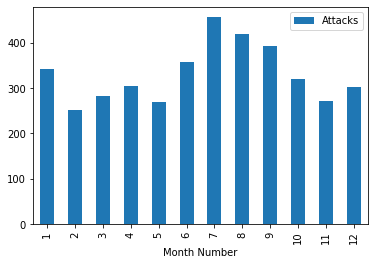

In [40]:
%matplotlib inline
sa_temp.groupby("Month Number").agg({"Attacks":"count"}).plot.bar()

In [41]:
sa_temp.head()

,Type,Attacks,Month,Month Number
0,Unprovoked,N,Sep,9
1,Unprovoked,N,Sep,9
2,Unprovoked,N,Sep,9
3,Unprovoked,N,Sep,9
4,Unprovoked,N,Sep,9


In [42]:
sa_temp_fatal = sa_temp[u.is_this("Y", lst = sa_temp['Attacks'])]
sa_temp_no_fatal = sa_temp[u.is_not_this("Y", lst = sa_temp['Attacks'])]

## Ataques mortales por mes

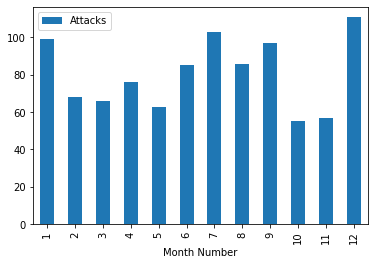

In [43]:
sa_temp_fatal.groupby("Month Number").agg({"Attacks":"count"}).plot.bar()

## Ataques no mortales por mes

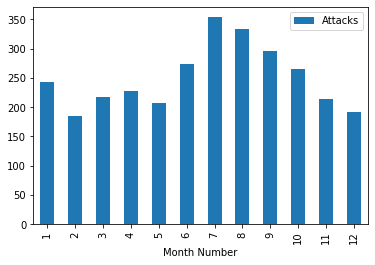

In [44]:
sa_temp_no_fatal.groupby("Month Number").agg({"Attacks":"count"}).plot.bar()

In [45]:
sa_temp["Fatal"] = sa_temp.Attacks.apply(lambda x: 1 if x == "Y" else 0)
sa_temp["No_Fatal"] = sa_temp.Attacks.apply(lambda x: 1 if x == "N" else 0)

In [46]:
sa_temp.head()

,Type,Attacks,Month,Month Number,Fatal,No_Fatal
0,Unprovoked,N,Sep,9,0,1
1,Unprovoked,N,Sep,9,0,1
2,Unprovoked,N,Sep,9,0,1
3,Unprovoked,N,Sep,9,0,1
4,Unprovoked,N,Sep,9,0,1


## Ataques mortales y no mortales

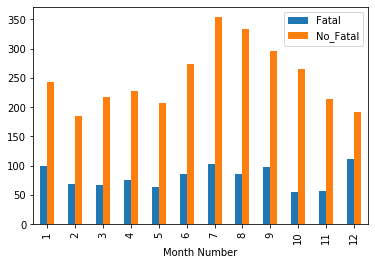

In [47]:
sa_temp.groupby("Month Number").agg({"Fatal":"sum", "No_Fatal":"sum"}).plot.bar()

In [48]:
sa_temp.head()

,Type,Attacks,Month,Month Number,Fatal,No_Fatal
0,Unprovoked,N,Sep,9,0,1
1,Unprovoked,N,Sep,9,0,1
2,Unprovoked,N,Sep,9,0,1
3,Unprovoked,N,Sep,9,0,1
4,Unprovoked,N,Sep,9,0,1


In [49]:
fatal_attacks = u.mean_attacks(sa_temp["Month Number"], sa_temp["Fatal"])
fatal_attacks

[99, 68, 66, 76, 63, 85, 103, 86, 97, 55, 57, 111]

In [50]:
nonfatal_attacks = u.mean_attacks(sa_temp["Month Number"], sa_temp["No_Fatal"])
nonfatal_attacks

[243, 184, 217, 228, 207, 273, 354, 334, 295, 265, 214, 192]

In [51]:
total_per_month = np.asarray(fatal_attacks) + np.asarray(nonfatal_attacks)
total_per_month

array([342, 252, 283, 304, 270, 358, 457, 420, 392, 320, 271, 303])

In [52]:
fatal_percent = np.asarray(fatal_attacks) / total_per_month
fatal_percent
nonfatal_percent = np.asarray(nonfatal_attacks) / total_per_month
nonfatal_percent
fatal_percent + nonfatal_percent

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Porcentaje de atques mortales y no mortales

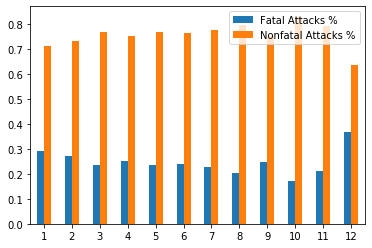

In [53]:
df = pd.DataFrame({'Fatal Attacks %': fatal_percent, 'Nonfatal Attacks %': nonfatal_percent}, index=months_dict.values())
ax = df.plot.bar(rot=0)

### Parece que aumenta lijeramente los ataques mortales los meses de invierno pero vamos a organizarlo por estaciones para ver si es así

In [54]:
sa_final.Country.value_counts().head()

USA                 1628
AUSTRALIA            882
SOUTH AFRICA         392
PAPUA NEW GUINEA     109
BRAZIL                84
Name: Country, dtype: int64

### Cogemos JSON de https://github.com/samayo/country-json/blob/master/src/country-by-geo-coordinates.json para tratar la estació por paises
    

In [55]:
import json
with open("src/countries.txt") as json_file:
    countries = json.load(json_file)

In [56]:
country = [e["country"] for e in countries]
north = [e["north"] for e in countries]
south = [e["south"] for e in countries]
west = [e["west"] for e in countries]
east = [e["east"] for e in countries]
d= {'Country': country, 'North': north, "South": south, "West": west, "East": east}
co = pd.DataFrame(data = d)
co.Country.iloc[227] = "USA"
co.North.isnull().sum()
co = co[co.North.notnull()].reset_index(drop=True)
co.head()

,Country,North,South,West,East
0,Afghanistan,38.4834,29.3775,60.4784,74.8794
1,Albania,42.6656,39.6484,19.294,21.0685
2,Algeria,37.0937,18.96,-8.67387,11.9795
3,American Samoa,-11.0497,-14.3825,-171.092,-169.416
4,Andorra,42.656,42.4285,1.40719,1.78654


### Vamos a quitar los paises nulos

In [57]:
sa_final.Country.isnull().sum()

26

In [58]:
sa_final_country = sa_final[sa_final.Country.notnull()]
sa_final_country.Country.isnull().sum()

0

In [59]:
result = [None]*len(sa_final_country.Country)
for k,e in enumerate(sa_final_country.Country):
    for i,c in enumerate(co.Country):
        if e.lower().strip() == c.lower().strip():
            if float(co.South[i]) < 0:
                result[k] = "South"
            else:
                result[k] = "North"

In [60]:
sa_final_country["Hemisphere"] = result
sa_final_country.Hemisphere.isnull().sum()
sa_final_country.head()

/home/jmpchamizo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Type,Country,Area,Location,Fatal,Month,Season,Hemisphere
0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",N,Sep,18-Sep-16,North
1,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",N,Sep,18-Sep-16,North
2,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",N,Sep,18-Sep-16,North
3,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,N,Sep,17-Sep-16,South
4,Unprovoked,AUSTRALIA,Victoria,Bells Beach,N,Sep,16-Sep-16,South


In [61]:
sa_final_country[sa_final_country.Hemisphere.isnull()]
(sa_final_country.Country[sa_final_country.Hemisphere.isnull()]).value_counts().head()

FIJI          55
SRI LANKA     10
ENGLAND       10
NEW GUINEA     9
COLUMBIA       8
Name: Country, dtype: int64

### Para las que nos quedan hacemos un diccionario:

In [62]:
count_dict = {"FIJI": "SOUTH","SRI LANKA": "NORTH", 
              "ENGLAND": "NORTH", "NEW GUINEA": "SOUTH",
              "COLUMBIA": "SOUTH", "TAIWAN": "SOUTH", "NEW BRITAIN": "NORTH",
              "OKINAWA": "NORTH", 
"LIBYA": "NORTH",
"SOUTH ATLANTIC OCEAN": "SOUTH",
"RUSSIA": "NORTH",
"ATLANTIC OCEAN": "NORTH",
"TURKS & CAICOS": "NORTH",
"BURMA": "NORTH",
"SCOTLAND": "NORTH",
"PERSIAN GULF":"NORTH",
"MICRONESIA":"SOUTH",
"Fiji":"SOUTH",
"MEDITERRANEAN SEA":"NORTH",
"NORTH PACIFIC OCEAN":"NORTH",
"CARIBBEAN SEA":"SOUTH",
"INDIAN OCEAN":"SOUTH",
"CURACAO":"NORTH",
"NETHERLANDS ANTILLES":"NORTH",
"WESTERN SAMOA":"SOUTH",
"EGYPT / ISRAEL":"NORTH",
"THE BALKANS":"NORTH",
"RED SEA":"NORTH",
"Between PORTUGAL & INDIA":"NORTH",
"FEDERATED STATES OF MICRONESI":"SOUTH",
"CEYLON (SRI LANKA)":"NORTH",
"GRAND CAYMAN":"NORTH",
"JOHNSTON ISLAND":"NORTH",
"NORTH ATLANTIC OCEAN":"NORTH",
"UNITED ARAB EMIRATES (UAE)": "NORTH",
"GULF OF ADEN":"NORTH",
"NORTHERN ARABIAN SEA":"NORTH",
"ANDAMAN / NICOBAR ISLANDAS" :"NORTH",
"KOREA":"NORTH",
"SOUTH CHINA SEA":"NORTH",
"BRITISH ISLES":"NORTH",
"IRAN / IRAQ":"NORTH",
"TASMAN SEA":"SOUTH",
"SOUTH PACIFIC OCEAN": "SOUTH",
"CRETE":"NORTH",
"RED SEA":"NORTH",
"TRINIDAD & TOBAGO":"NORTH",
"BRITISH WEST INDIES":"NORTH",
"BAHREIN":"NORTH",
"MONTENEGRO":"NORTH",
"BRITISH NEW GUINEA":"NORTH",
"ADMIRALTY ISLANDS":"SOUTH"}

In [63]:
for k,e in enumerate(sa_final_country.Country):
    for c,i in count_dict.items():
        if e.lower().strip() == c.lower().strip():
            result[k] = i

## Dejamos el resultado en una la columna Hemisphere

In [64]:
sa_final_country["Hemisphere"] = result
sa_final_country.Hemisphere.isnull().sum()
sa_final_country = sa_final_country[sa_final_country.Hemisphere.notnull()].reset_index(drop=True)
sa_final_country.head()

/home/jmpchamizo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Type,Country,Area,Location,Fatal,Month,Season,Hemisphere
0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",N,Sep,18-Sep-16,North
1,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",N,Sep,18-Sep-16,North
2,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",N,Sep,18-Sep-16,North
3,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,N,Sep,17-Sep-16,South
4,Unprovoked,AUSTRALIA,Victoria,Bells Beach,N,Sep,16-Sep-16,South


In [65]:
seasons =["Winter", "Winter", "Spring", "Spring", "Spring", "Summer", "Summer", "Summer", "Fall", "Fall", "Fall", "Winter"]

In [66]:
months_dict = {e: i+1 for i,e in enumerate(months)}
sa_final_country["Month Number"] = sa_final_country.Month.map(months_dict)
sa_final_country = sa_final_country[sa_final_country["Month Number"].notnull()].reset_index(drop = "True")

## Calculamos la estación del año lo volcamos a seasons

In [67]:
result = [None]*len(sa_final_country.Hemisphere)
for i,e in enumerate(sa_final_country.Hemisphere):
    month = sa_final_country["Month Number"][i]
    if e == "North":
        if (int(month) + 1) < len(seasons):
            result[i] = seasons[int(month) +1]
        else:
            result[i] = seasons[int(0)]
    else:
        if (int(month) + 7) < len(seasons):
            result[i] = seasons[int(month) + 7]
        else:
            result[i] = seasons[int(month) - 5]

In [68]:
sa_final_country.Season = result
sa_final_country.head()

,Type,Country,Area,Location,Fatal,Month,Season,Hemisphere,Month Number
0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",N,Sep,Fall,North,9.0
1,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",N,Sep,Fall,North,9.0
2,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",N,Sep,Fall,North,9.0
3,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,N,Sep,Spring,South,9.0
4,Unprovoked,AUSTRALIA,Victoria,Bells Beach,N,Sep,Spring,South,9.0


## Nos quedamos con las columnas que necesitaremos para representar los resultados

In [69]:
sa_final_hemisphere = sa_final_country.drop(["Country", "Type", "Area", "Location", "Month", "Hemisphere", "Month Number"], axis=1)

In [70]:
sa_final_hemisphere.head()

,Fatal,Season
0,N,Fall
1,N,Fall
2,N,Fall
3,N,Spring
4,N,Spring


In [71]:
sa_final_hemisphere = sa_final_hemisphere.rename(columns={'Fatal':'Attacks'})
sa_final_hemisphere["Fatal"] = sa_final_hemisphere.Attacks.apply(lambda x: 1 if x == "Y" else 0)
sa_final_hemisphere["No_Fatal"] = sa_final_hemisphere.Attacks.apply(lambda x: 1 if x == "N" else 0)
sa_final_hemisphere.head()

,Attacks,Season,Fatal,No_Fatal
0,N,Fall,0,1
1,N,Fall,0,1
2,N,Fall,0,1
3,N,Spring,0,1
4,N,Spring,0,1


## Ataques mortales y no mortales por estación

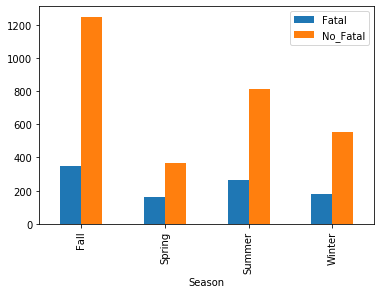

In [72]:
sa_final_hemisphere.groupby("Season").agg({"Fatal":"sum", "No_Fatal":"sum"}).plot.bar()

In [73]:
nfatal_attacks = u.mean_attacks_hemisphere(sa_final_hemisphere.Season, sa_final_hemisphere.Fatal)
nfatal_attacks

[350, 160, 261, 179]

In [74]:
nnonfatal_attacks = u.mean_attacks_hemisphere(sa_final_hemisphere.Season, sa_final_hemisphere.No_Fatal)
nnonfatal_attacks

[1250, 369, 813, 556]

In [75]:
total_per_season = np.asarray(nfatal_attacks) + np.asarray(nnonfatal_attacks)
total_per_season

array([1600,  529, 1074,  735])

In [76]:
nfatal_percent = np.asarray(nfatal_attacks) / total_per_season
print(nfatal_percent)
nnonfatal_percent = np.asarray(nnonfatal_attacks) / total_per_season
print(nnonfatal_percent)
nfatal_percent + nnonfatal_percent

[0.21875    0.30245747 0.24301676 0.24353741]
[0.78125    0.69754253 0.75698324 0.75646259]


array([1., 1., 1., 1.])

## Porcentaje de ataques mortales y no mortales

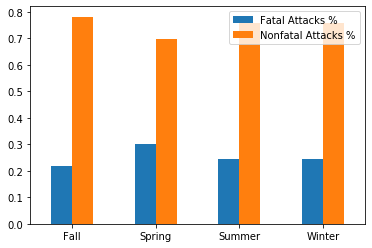

In [77]:
ndf = pd.DataFrame({'Fatal Attacks %': nfatal_percent, 'Nonfatal Attacks %': nnonfatal_percent}, index= ["Fall", "Spring", "Summer", "Winter"])
ndf.plot.bar(rot=0)

# Pues no parece que la estación del año influya en la agresividad del tiburón